1. Load data

In [2]:
import pandas as pd
data = pd.read_csv('data.csv')
data = data.drop(columns=['is_weekend','is_holiday','zone_desc','oneway','geometry','zone_group','bldg_density'])
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3213 non-null   int64  
 1   magnitude_of_delay     3213 non-null   int64  
 2   from                   3213 non-null   object 
 3   to                     3213 non-null   object 
 4   length                 3213 non-null   float64
 5   flow_speed             3213 non-null   float64
 6   travel_time            3213 non-null   float64
 7   risk                   3213 non-null   int64  
 8   is_heavy_traffic       3213 non-null   float64
 9   is_lane_closed         3213 non-null   int64  
 10  is_queuing_traffic     3213 non-null   int64  
 11  is_slow_traffic        3213 non-null   int64  
 12  is_stationary_traffic  3213 non-null   int64  
 13  day_of_week            3213 non-null   int64  
 14  hour_of_day            3213 non-null   int64  
 15  is_w

Train and test sets have unique street names.


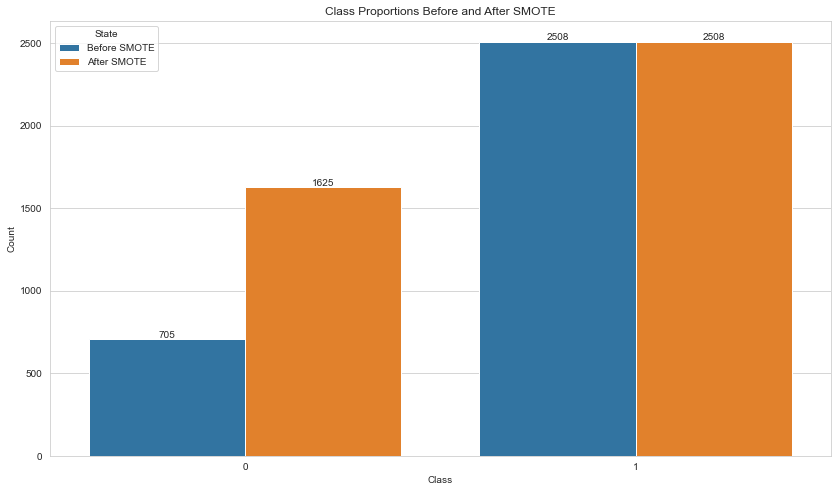

Training data shape after SMOTE: (2850, 29)
Testing data shape: (1283, 29)


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np

# Sort data by 'from' column
data = data.sort_values(by='from').reset_index(drop=True)

# Randomly select 30% of the street names
unique_streets = data['from'].unique()
np.random.seed(42)
test_streets = np.random.choice(unique_streets, size=int(0.3 * len(unique_streets)), replace=False)

# Split the data based on the selected street names
test_data = data[data['from'].isin(test_streets)]
train_data = data[~data['from'].isin(test_streets)]

# Verify that the street names are unique between the two sets
train_streets = set(train_data['from'])
test_streets_set = set(test_data['from'])
if train_streets.isdisjoint(test_streets_set):
    print("Train and test sets have unique street names.")
else:
    raise ValueError("Train and test sets share some street names!")

# Define features and target variable
X_train = train_data.drop(columns=['risk', 'from', 'to'])
y_train = train_data['risk']
X_test = test_data.drop(columns=['risk', 'from', 'to'])
y_test = test_data['risk']

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Ensure 'risk' is binary
y_train_resampled = y_train_resampled.astype(int)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Save the training and testing datasets to CSV files
X_train_resampled['risk'] = y_train_resampled
X_test['risk'] = y_test
X_train_resampled.to_csv('training.csv', index=False)
X_test.to_csv('testing.csv', index=False)

# Visualize class distribution before and after SMOTE
class_counts_before = data['risk'].value_counts()
class_counts_train_resampled = y_train_resampled.value_counts()
class_counts_test = y_test.value_counts()

# Combine training set after SMOTE with the test set
combined_counts_after = class_counts_train_resampled.add(class_counts_test, fill_value=0)

# Create DataFrame for visualization
class_counts_df = pd.DataFrame({
    'Class': class_counts_before.index,
    'Before SMOTE': class_counts_before.values,
    'After SMOTE': [combined_counts_after[val] for val in class_counts_before.index]
})

# Melt the DataFrame for easier plotting with seaborn
class_counts_melted = class_counts_df.melt(id_vars='Class', var_name='State', value_name='Count')

# Set the background color to white
sns.set_style("whitegrid")

# Plot the bar chart
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Class', y='Count', hue='State', data=class_counts_melted)
plt.title('Class Proportions Before and After SMOTE')

# Add numerical labels on each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', xy=(p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

# Set the facecolor of the plot to white
ax.set_facecolor('white')
plt.show()

# Verify the shapes of the datasets
print("Training data shape after SMOTE:", X_train_resampled.shape)
print("Testing data shape:", X_test.shape)


**Model Implementation**

Decision Tree CV Scores: [0.97719298 0.99824561 0.9245614  0.85438596 0.95789474]
Random Forest CV Scores: [0.98421053 0.99649123 0.94210526 0.85087719 0.98421053]
XGBoost CV Scores: [0.98245614 0.99824561 0.94912281 0.85263158 0.97894737]
Decision Tree Classifier Report
              precision    recall  f1-score   support

           0       0.51      0.94      0.66       200
           1       0.99      0.84      0.91      1083

    accuracy                           0.85      1283
   macro avg       0.75      0.89      0.78      1283
weighted avg       0.91      0.85      0.87      1283

Training Accuracy: 0.9982456140350877
Testing Accuracy: 0.8519095869056897
PR AUC: 0.9801885987174479

Random Forest Classifier Report
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       200
           1       0.96      0.99      0.97      1083

    accuracy                           0.96      1283
   macro avg       0.95      0.88      0.91     

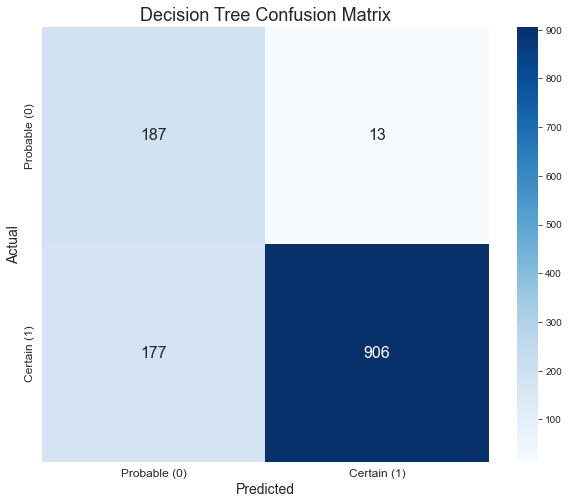

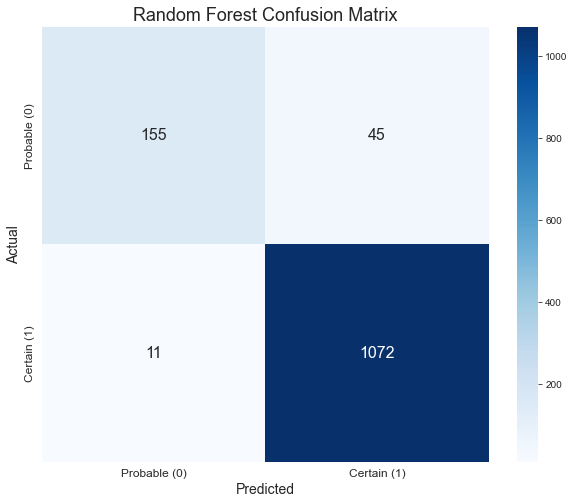

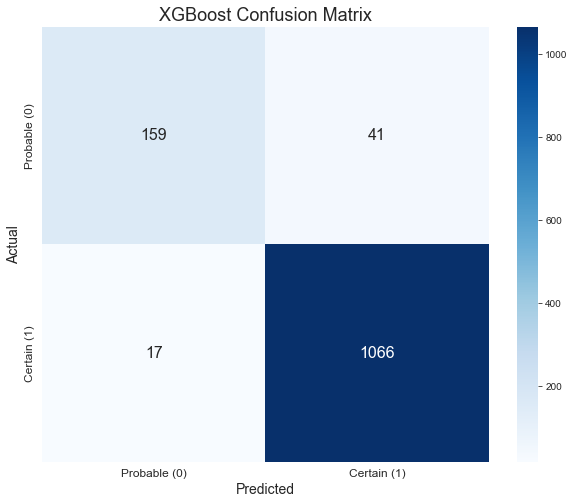

In [17]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_tree as xgb_plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, auc
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the training and testing datasets
train_data = pd.read_csv('training.csv')
test_data = pd.read_csv('testing.csv')

# Separate features and target variable from training and testing datasets
X_train = train_data.drop(columns=['risk'])
y_train = train_data['risk']
X_test = test_data.drop(columns=['risk'])
y_test = test_data['risk']

# Optimal hyperparameters for the models
best_dt_params = {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
best_rf_params = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
best_xgb_params = {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}

# Create and train the Decision Tree model with best hyperparameters
dt_model = DecisionTreeClassifier(**best_dt_params)
dt_model.fit(X_train, y_train)

# Create and train the Random Forest model with best hyperparameters
rf_model = RandomForestClassifier(**best_rf_params)
rf_model.fit(X_train, y_train)

# Create and train the XGBoost model with best hyperparameters
xgb_model = XGBClassifier(**best_xgb_params)
xgb_model.fit(X_train, y_train)

# Perform cross-validation on the training set
dt_cv_scores = cross_val_score(dt_model, X_train, y_train, cv=5)
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
xgb_cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5)

print(f"Decision Tree CV Scores: {dt_cv_scores}")
print(f"Random Forest CV Scores: {rf_cv_scores}")
print(f"XGBoost CV Scores: {xgb_cv_scores}")

# Predict and evaluate the models on the test set
dt_predictions = dt_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)

# Calculate training and testing accuracies
dt_train_acc = accuracy_score(y_train, dt_model.predict(X_train))
dt_test_acc = accuracy_score(y_test, dt_predictions)

rf_train_acc = accuracy_score(y_train, rf_model.predict(X_train))
rf_test_acc = accuracy_score(y_test, rf_predictions)

xgb_train_acc = accuracy_score(y_train, xgb_model.predict(X_train))
xgb_test_acc = accuracy_score(y_test, xgb_predictions)

# Calculate Precision-Recall AUC
def calculate_pr_auc(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    return auc(recall, precision)

dt_pr_auc = calculate_pr_auc(y_test, dt_model.predict_proba(X_test)[:, 1])
rf_pr_auc = calculate_pr_auc(y_test, rf_model.predict_proba(X_test)[:, 1])
xgb_pr_auc = calculate_pr_auc(y_test, xgb_model.predict_proba(X_test)[:, 1])

# Print classification reports and accuracy scores
print("Decision Tree Classifier Report")
print(classification_report(y_test, dt_predictions))
print("Training Accuracy:", dt_train_acc)
print("Testing Accuracy:", dt_test_acc)
print("PR AUC:", dt_pr_auc)

print("\nRandom Forest Classifier Report")
print(classification_report(y_test, rf_predictions))
print("Training Accuracy:", rf_train_acc)
print("Testing Accuracy:", rf_test_acc)
print("PR AUC:", rf_pr_auc)

print("\nXGBoost Classifier Report")
print(classification_report(y_test, xgb_predictions))
print("Training Accuracy:", xgb_train_acc)
print("Testing Accuracy:", xgb_test_acc)
print("PR AUC:", xgb_pr_auc)

# Visualize confusion matrix for each model
def plot_confusion_matrix(y_true, y_pred, model_name):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))  # Increase figure size for better readability
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Probable (0)', 'Certain (1)'], yticklabels=['Probable (0)', 'Certain (1)'], annot_kws={"size": 16})  # Increase annotation size
    plt.title(f'{model_name} Confusion Matrix', fontsize=18)  # Increase title font size
    plt.xlabel('Predicted', fontsize=14)  # Increase x-axis label font size
    plt.ylabel('Actual', fontsize=14)  # Increase y-axis label font size
    plt.xticks(fontsize=12)  # Increase x-tick label font size
    plt.yticks(fontsize=12)  # Increase y-tick label font size
    plt.show()

plot_confusion_matrix(y_test, dt_predictions, "Decision Tree")
plot_confusion_matrix(y_test, rf_predictions, "Random Forest")
plot_confusion_matrix(y_test, xgb_predictions, "XGBoost")


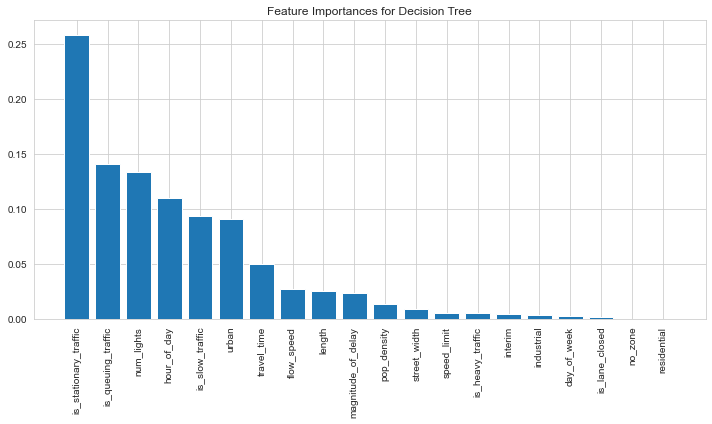

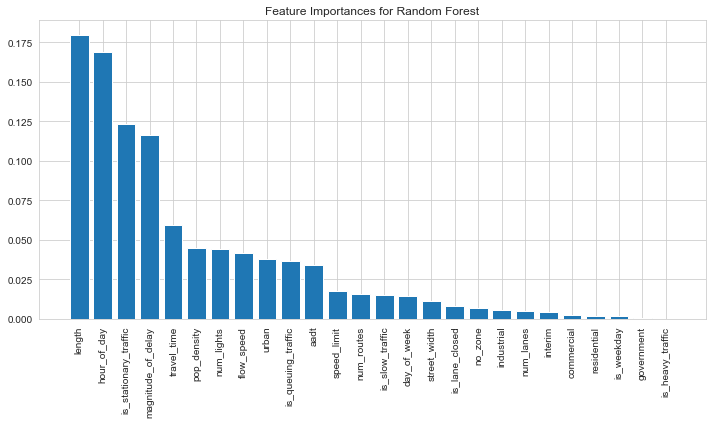

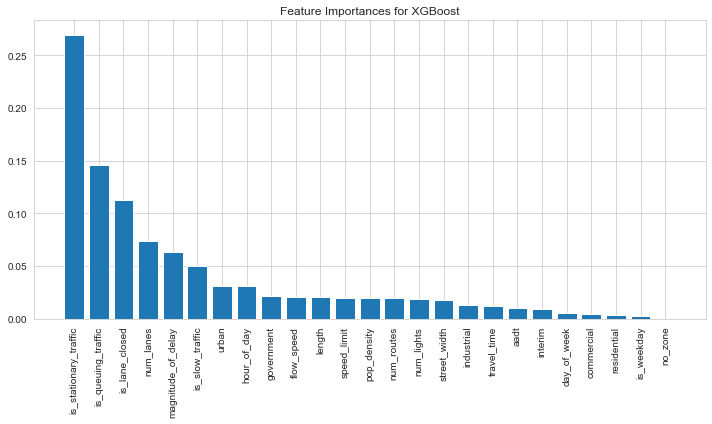

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Load the training and testing datasets
train_data = pd.read_csv('training.csv')
test_data = pd.read_csv('testing.csv')

# Separate features and target variable from training and testing datasets
X_train = train_data.drop(columns=['risk', 'id'])
y_train = train_data['risk']
X_test = test_data.drop(columns=['risk', 'id'])
y_test = test_data['risk']

# Optimal hyperparameters for the models
best_dt_params = {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
best_rf_params = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
best_xgb_params = {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}

# Create and train the Decision Tree model with best hyperparameters
dt_model = DecisionTreeClassifier(**best_dt_params)
dt_model.fit(X_train, y_train)

# Create and train the Random Forest model with best hyperparameters
rf_model = RandomForestClassifier(**best_rf_params)
rf_model.fit(X_train, y_train)

# Create and train the XGBoost model with best hyperparameters
xgb_model = XGBClassifier(**best_xgb_params)
xgb_model.fit(X_train, y_train)

# Feature importances
def plot_feature_importances(model, model_name, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Remove features with zero importance
    non_zero_indices = [i for i in indices if importances[i] > 0]
    non_zero_importances = importances[non_zero_indices]
    non_zero_feature_names = [feature_names[i] for i in non_zero_indices]
    
    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importances for {model_name}')
    plt.bar(range(len(non_zero_importances)), non_zero_importances, align='center')
    plt.xticks(range(len(non_zero_importances)), non_zero_feature_names, rotation=90)
    plt.tight_layout()
    plt.show()

plot_feature_importances(dt_model, 'Decision Tree', X_train.columns)
plot_feature_importances(rf_model, 'Random Forest', X_train.columns)
plot_feature_importances(xgb_model, 'XGBoost', X_train.columns)


In [ ]:
# Find the road segments with high incident count and low bus route coverage
incident_counts = data['id'].value_counts().reset_index()
incident_counts.columns = ['id', 'incident_count']
data_with_counts = data.merge(incident_counts, on='id')

high_incident_low_bus = data_with_counts[(data_with_counts['incident_count'] > data_with_counts['incident_count'].mean()) & 
                                         (data_with_counts['num_routes'] < data_with_counts['num_routes'].mean())]

# Ensure unique IDs and select three road segments
selected_segments = high_incident_low_bus.drop_duplicates(subset='id').head(10)
print(f"Selected road segments: {selected_segments['id'].values}")

# Train an XGBoost classification model
xgb_model = XGBClassifier(colsample_bytree=0.3, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1.0)
xgb_model.fit(X_train_resampled.drop(columns=['risk']), y_train_resampled)

# Predict and iterate bus routes for each selected segment
additional_routes_range = range(1, 100)
for i, segment in selected_segments.iterrows():
    segment_id = segment['id']
    print(f"\nSegment ID: {segment_id}")
    
    segment_features = segment[X_train.columns].values.reshape(1, -1)
    predicted_label = xgb_model.predict(segment_features)[0]
    print(f"Initial predicted label for the segment: {predicted_label}")

    # Iterate bus routes and observe the predicted label
    predicted_labels = []
    for additional_routes in additional_routes_range:
        modified_features = segment[X_train.columns].copy()
        modified_features['num_routes'] += additional_routes
        new_predicted_label = xgb_model.predict([modified_features.values])[0]
        predicted_labels.append(new_predicted_label)
        # print(f"With {additional_routes} additional bus routes, the predicted label is: {new_predicted_label}")

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(additional_routes_range, predicted_labels, marker='o')
    plt.title(f'Effect of Additional Bus Routes on Incident Likelihood for Segment ID {segment_id}')
    plt.xlabel('Additional Bus Routes')
    plt.ylabel('Predicted Incident Likelihood')
    plt.xticks(additional_routes_range)
    plt.grid(True)
    plt.show()